# Color deconvolution of immunostained histology images
<a href="http://www.ncbi.nlm.nih.gov/pubmed/11531144">Ruifrok's color deconvolution algorithm</a> is very commonly used in image processing of histological images. The algorithm separates the different color channels in an image by transforming the image from the RGB space to a color space defined by the histological stains. This transformation relies on a matrix containing the stain colors. Although stain colors vary quite a lot between different laboratories and even different images, most people use standard values for color deconvolution. Surprisingly, these standard values work fairly well for most purposes.

In this notebook, I use <a href="http://scikit-image.org/docs/dev/auto_examples/plot_ihc_color_separation.html">python skimage</a> to compare two commonly used standard matrices for color deconvolution of an Hematoxylin-DAB-immunostained image.

## Initialize

In [131]:
# import libraries
from PIL import Image
from StringIO import StringIO
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import requests
%matplotlib inline

##Import source image

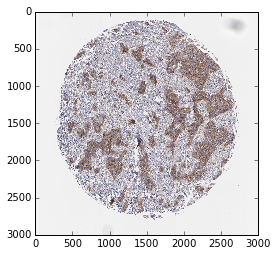

In [132]:
# get image from proteinatlas
url = 'http://www.proteinatlas.org/images/1383/4496_A_4_2.jpg'
response = requests.get(url)
img = Image.open(StringIO(response.content))
imshow(np.asarray(img))

## Perform color deconvolution using skimage

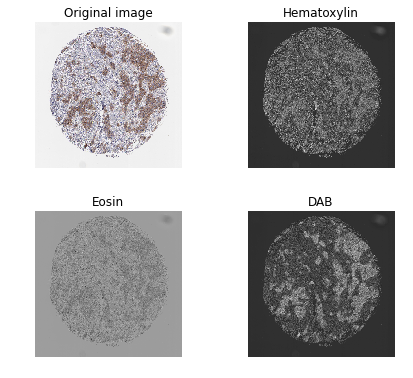

In [133]:
# import scikit-image color deconvolution
from skimage.color import rgb2hed

# transform RGB to HED colorspace
ihc_hed = rgb2hed(img)

# prepare plot
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax0, ax1, ax2, ax3 = axes.ravel()

# plot all channels
ax0.imshow(img)
ax0.set_title("Original image")
ax1.imshow(ihc_hed[:, :, 0], cmap=plt.cm.gray)
ax1.set_title("Hematoxylin")
ax2.imshow(ihc_hed[:, :, 1], cmap=plt.cm.gray)
ax2.set_title("Eosin")
ax3.imshow(ihc_hed[:, :, 2], cmap=plt.cm.gray)
ax3.set_title("DAB")

# plot decorations
for ax in axes.ravel():
    ax.axis('off')
fig.subplots_adjust(hspace=0.3)

###Analyze eosin (= residual) channel
In the present case, the sample is stained with hematoxylin and DAB only, so the eosin channel should represent the residual. Ideally, the eosin channel should be empty.

<matplotlib.colorbar.Colorbar instance at 0x1165b91b8>

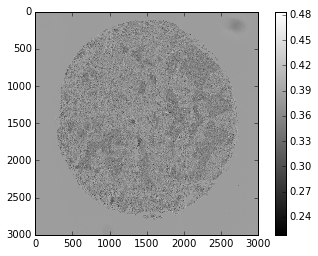

In [134]:
imshow(ihc_hed[:, :, 1],cmap=plt.cm.gray)
plt.colorbar()

We see that the eosin channel is not quite empty, so some information is lost during color deconvolution.
## Change standard values for deconvolution vectors
more information: https://github.com/scikit-image/scikit-image/blob/master/skimage/color/colorconv.py
### Manually call color deconvolution function with skimage standard values

In [135]:
from scipy import linalg
from skimage.color import separate_stains

# Ruifrok's standard values, copied from skimage source
rgb_from_hed = np.array([[0.65, 0.70, 0.29],
                         [0.07, 0.99, 0.11],
                         [0.27, 0.57, 0.78]])
hed_from_rgb = linalg.inv(rgb_from_hed)

# perform color deconvolution
img_hed_custom = separate_stains(img, hed_from_rgb)

# restore original rgb image
from skimage.color import combine_stains
original_img_restored = combine_stains(img_hed_custom, rgb_from_hed)

print('HED deconvolution matrix: ')
print(rgb_from_hed)

HED deconvolution matrix: 
[[ 0.65  0.7   0.29]
 [ 0.07  0.99  0.11]
 [ 0.27  0.57  0.78]]


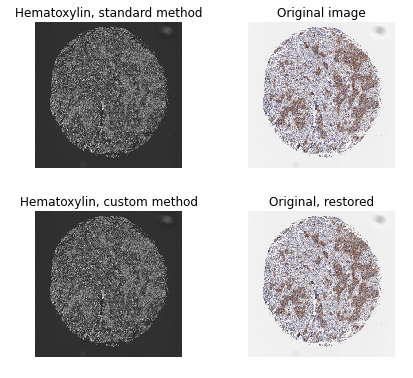

In [136]:
# prepare plot
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax0, ax1, ax2, ax3 = axes.ravel()

# plot all channels
ax0.imshow(ihc_hed[:, :, 0], cmap=plt.cm.gray)
ax0.set_title("Hematoxylin, standard method")
ax1.imshow(img)
ax1.set_title("Original image")
ax2.imshow(img_hed_custom[:, :, 0], cmap=plt.cm.gray)
ax2.set_title("Hematoxylin, custom method")
ax3.imshow(original_img_restored)
ax3.set_title("Original, restored")

# plot decorations
for ax in axes.ravel():
    ax.axis('off')
fig.subplots_adjust(hspace=0.3)

This was just an internal check confirming that

* color deconvolution with skimage's standard values yields the same result when overwriting these values manually
* the process is fully reversible by back-projection to the RGB space

### Manually call color deconvolution function with Fiji standard values

In [137]:
# Fiji standard values for Hematoxylin-DAB (HDAB) color deconvolution
Blue_Fiji = [0.6500286, 0.704031, 0.2860126]
Brown_Fiji = [0.26814753, 0.57031375, 0.77642715]
Residual_Fiji = [0.7110272, 0.42318153, 0.5615672]

# concatenate color vectors
rgb_from_hdab = np.array([Blue_Fiji, Brown_Fiji, Residual_Fiji])
hdab_from_rgb = linalg.inv(rgb_from_hdab)

# perform color deconvolution
img_hdab_custom = separate_stains(img, hdab_from_rgb)

# restore original rgb image
original_img_restored_hdab = combine_stains(img_hdab_custom, rgb_from_hdab)

print('HDAB deconvolution matrix: ')
print(rgb_from_hdab)

HDAB deconvolution matrix: 
[[ 0.6500286   0.704031    0.2860126 ]
 [ 0.26814753  0.57031375  0.77642715]
 [ 0.7110272   0.42318153  0.5615672 ]]


## Compare skimage to Fiji standard values

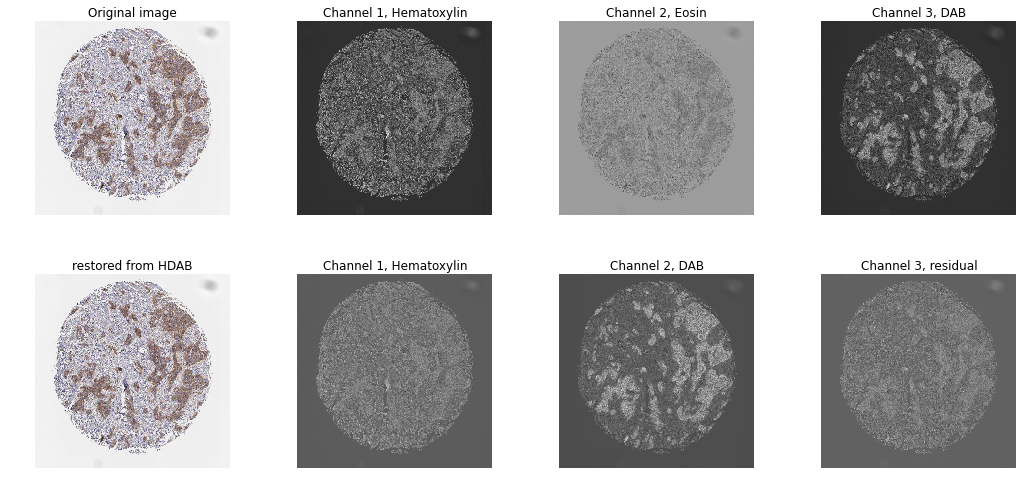

In [138]:
# prepare plot
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes.ravel()

# plot all channels
ax0.imshow(img, cmap=plt.cm.gray)
ax0.set_title("Original image")
ax1.imshow(ihc_hed[:, :, 0], cmap=plt.cm.gray)
ax1.set_title("Channel 1, Hematoxylin")
ax2.imshow(ihc_hed[:, :, 1], cmap=plt.cm.gray)
ax2.set_title("Channel 2, Eosin")
ax3.imshow(ihc_hed[:, :, 2], cmap=plt.cm.gray)
ax3.set_title("Channel 3, DAB")
ax4.imshow(original_img_restored_hdab)
ax4.set_title("restored from HDAB")
ax5.imshow(img_hdab_custom[:, :, 0], cmap=plt.cm.gray)
ax5.set_title("Channel 1, Hematoxylin")
ax6.imshow(img_hdab_custom[:, :, 1], cmap=plt.cm.gray)
ax6.set_title("Channel 2, DAB")
ax7.imshow(img_hdab_custom[:, :, 2], cmap=plt.cm.gray)
ax7.set_title("Channel 3, residual")

# decorations
for ax in axes.ravel():
    ax.axis('off')
fig.subplots_adjust(hspace=0.3)

It seems that the HED transformation using skimage standard values yields a better color deconvolution than Fiji's standard values.

Often, the DAB channel is the most interesting one (e.g. for quantification of immunostaining or object recognition). Comparison of DAB channels from both methods yields:

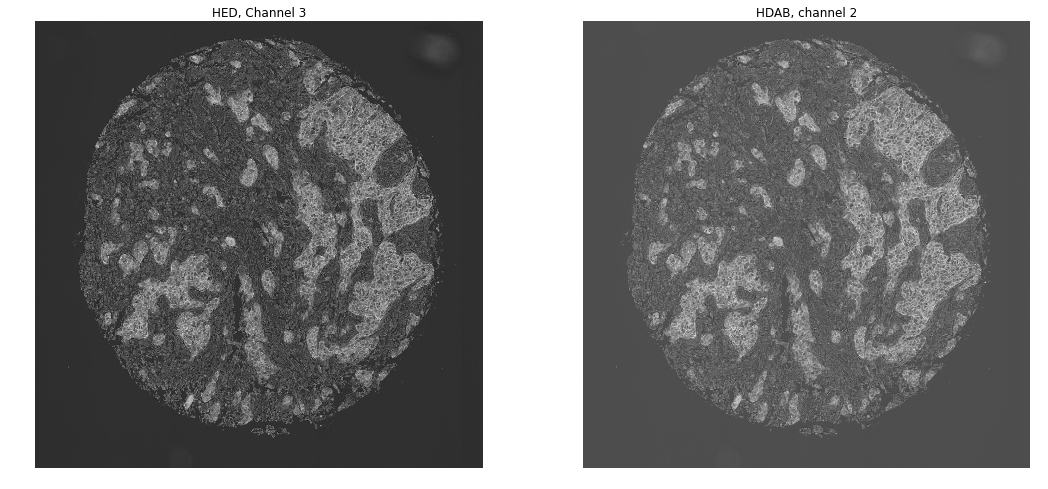

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
ax0, ax1 = axes.ravel()

ax0.imshow(ihc_hed[:, :, 2], cmap=plt.cm.gray)
ax0.set_title("HED, Channel 3")

ax1.imshow(img_hdab_custom[:, :, 1], cmap=plt.cm.gray)
ax1.set_title("HDAB, channel 2")

for ax in axes.ravel():
    ax.axis('off')
fig.subplots_adjust(hspace=0.3)

<b>Conclusion: For this image, the standard values from skimage are better suited than the standard values from Fiji.</b>